# 1. Import Data 

In [1]:
import pandas as pd

# Training set - Initial dataset
data = pd.read_csv ('dataframe1.csv')   
dataframe = pd.DataFrame(data)

# Validation set - B02
data2 = pd.read_csv ('dataframe2.csv')   
dataframe2 = pd.DataFrame(data2)

# Test set - B03
data3 = pd.read_csv ('dataframe3.csv')   
dataframe3 = pd.DataFrame(data3)

# Prices OHLC
price = pd.read_csv ('prices_ohlc.csv')   
prices = pd.DataFrame(price)

---
# 2. Exploratory Data Analysis 

Text(0.5, 1.0, 'Correlation Heatmap')

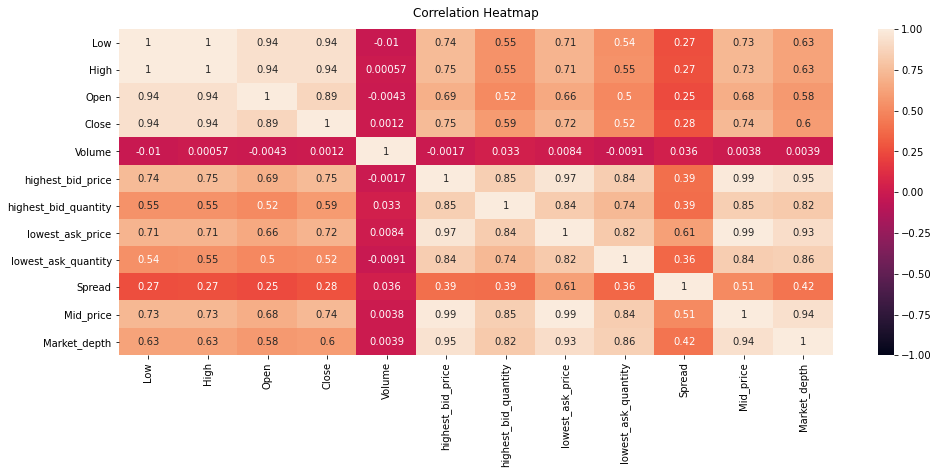

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation heatmap of training set
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

It can be seen that Close price is strongly correlated with Low price, High price, Open price, highest bid price, lowest ask price, mid price. It is moderatly correlated with market depth, highest bid quantity, lowest ask quantity. And poorly correlated with volume and spread.

---
# 3. Install and Import dependencies for Reinforcement Learning Model

In [3]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

     |████████████████████████████████| 1.1 MB 29.2 MB/s            
     |████████████████████████████████| 2.8 MB 105.6 MB/s            
Reason for being yanked: re-release with new wheels
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [4]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


---
# 4. Build environment & train

In [5]:
from gym_anytrading.envs import StocksEnv

### Model 1
<b>Signal Features:
    1. High price
    2. Low price
    3. Open price
    4. Close price
    5. Volume
    6. Highest bid price
    7. Highest bid quantity
    8. Lowest ask price
    9. Lowest ask quantity
    10. Spread
    11. Mid price
    12. Market depth

In [6]:
env = gym.make('stocks-v0', df=prices, frame_bound=(10,600), window_size=10)

In [7]:
# Create new environment 
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    price = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['High','Open','Low','Close','Volume','highest_bid_price','highest_bid_quantity','lowest_ask_price','lowest_ask_quantity','Spread','Mid_price','Market_depth']].to_numpy()[start:end]
    return price, signal_features

class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=dataframe, window_size=10, frame_bound=(10,600))

In [8]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [58]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=300000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | -0.0203  |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 0.691    |
| total_timesteps    | 5        |
| value_loss         | 0.757    |
---------------------------------
---------------------------------
| explained_variance | -0.363   |
| fps                | 512      |
| nupdates           | 100      |
| policy_entropy     | 0.689    |
| total_timesteps    | 500      |
| value_loss         | 0.982    |
---------------------------------
---------------------------------
| explained_variance | -0.00187 |
| fps                | 589      |
| nupdates           | 200      |
| policy_entropy     | 0.689    |
| total_timesteps    | 1000     |
| value_loss         | 93.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0131  |
| fps                | 621      |
| nupdates           | 300      |
| policy_entr

info {'total_reward': 149.0, 'total_profit': 1.719464676423678, 'position': 0}


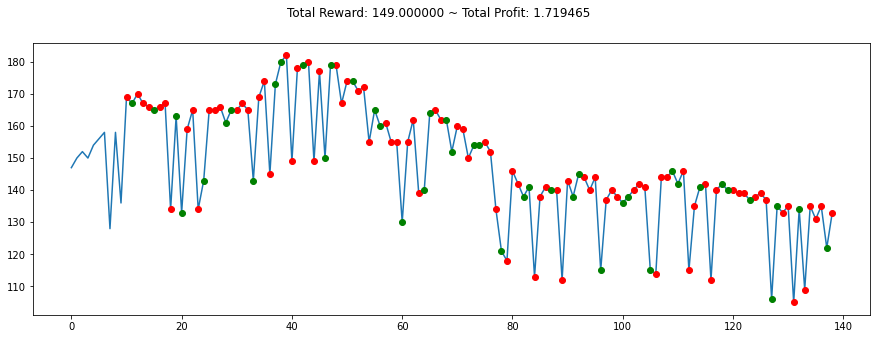

In [59]:
# Test set splitted from original dataframe
env = MyCustomEnv(df=dataframe, window_size=10, frame_bound=(600,729))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,5))
plt.cla()
env.render_all()
plt.show()

<b>Model 1 Profit using original dataframe test set = 71.9% return

info {'total_reward': 19.0, 'total_profit': 1.0242594772689468, 'position': 0}


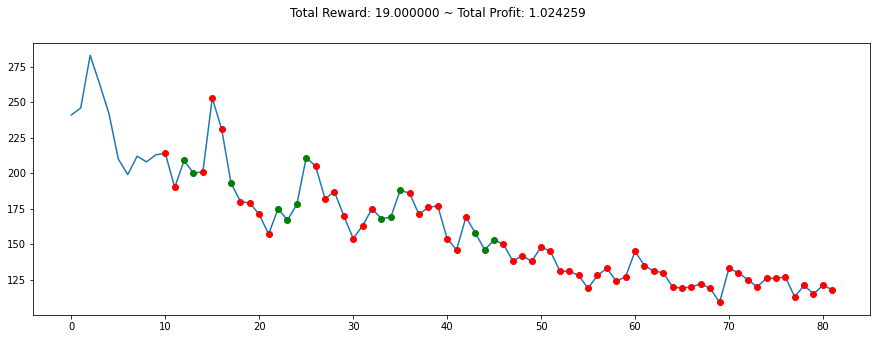

In [74]:
# Validation Set - B02
env = MyCustomEnv(df=dataframe2, window_size=10, frame_bound=(10,82))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,5))
plt.cla()
env.render_all()
plt.show()

<b>Model 1 Profit using validation set B02 = 2.4% return

### Model 2
We only take variables that has stronger correlation with Close price (ie. correlation coefficient > 0.6)

<b>Signal Features:
    1. High price
    2. Low price
    3. Open price
    4. Close price
    5. Highest bid price
    6. Lowest ask price
    7. Mid price
    8. Market depth

In [75]:
env_m2 = gym.make('stocks-v0', df=prices, frame_bound=(10,600), window_size=10)

In [77]:
# Create new environment 
def add_signals_m2(env_m2):
    start = env_m2.frame_bound[0] - env_m2.window_size
    end = env_m2.frame_bound[1]
    price = env_m2.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env_m2.df.loc[:, ['High','Open','Low','Close','highest_bid_price','lowest_ask_price','Mid_price','Market_depth']].to_numpy()[start:end]
    return price, signal_features

class MyCustomEnv_m2(StocksEnv):
    _process_data = add_signals_m2
    
env2_m2 = MyCustomEnv_m2(df=dataframe, window_size=10, frame_bound=(10,600))

In [78]:
env_maker_m2 = lambda: env2_m2
env_m2 = DummyVecEnv([env_maker_m2])

In [81]:
model_m2 = A2C('MlpLstmPolicy', env_m2, verbose=1) 
model_m2.learn(total_timesteps=300000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | -0.358   |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 23.9     |
---------------------------------
---------------------------------
| explained_variance | -8.38    |
| fps                | 514      |
| nupdates           | 100      |
| policy_entropy     | 0.692    |
| total_timesteps    | 500      |
| value_loss         | 4.23e-05 |
---------------------------------
----------------------------------
| explained_variance | -0.000339 |
| fps                | 593       |
| nupdates           | 200       |
| policy_entropy     | 0.692     |
| total_timesteps    | 1000      |
| value_loss         | 311       |
----------------------------------
---------------------------------
| explained_variance | -0.00109 |
| fps                | 625      |
| nupdates           | 300      |
| pol

info {'total_reward': 115.0, 'total_profit': 1.5748140582870476, 'position': 0}


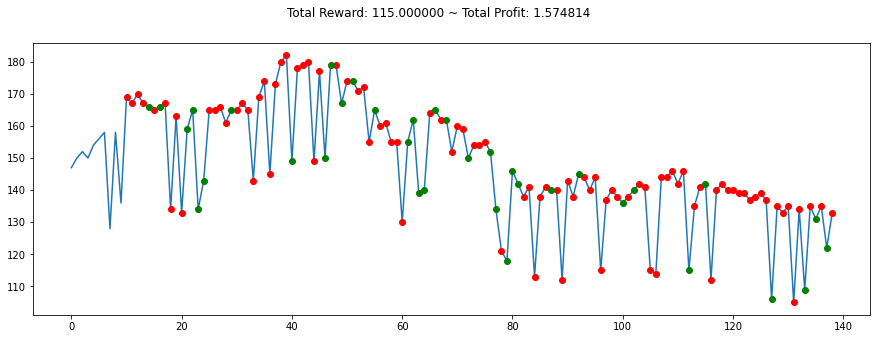

In [88]:
# Test set splitted from original dataframe
env = MyCustomEnv_m2(df=dataframe, window_size=10, frame_bound=(600,729))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model_m2.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,5))
plt.cla()
env.render_all()
plt.show()

<b>Model 2 Profit using original dataframe test set = 57.5% return

info {'total_reward': 20.0, 'total_profit': 1.018007033319805, 'position': 0}


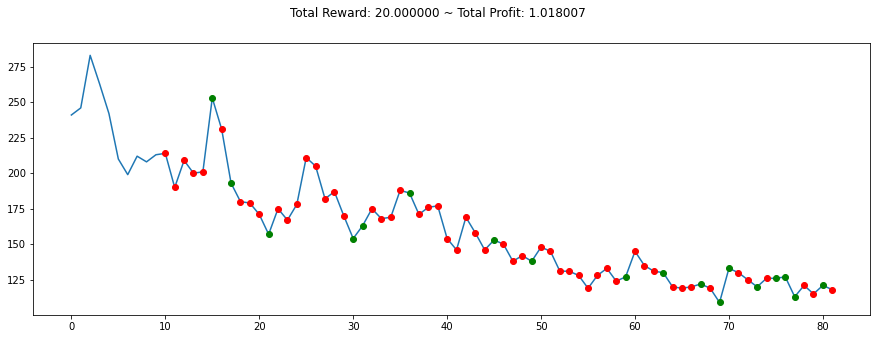

In [102]:
# Validation Set - B02
env = MyCustomEnv_m2(df=dataframe2, window_size=10, frame_bound=(10,82))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model_m2.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,5))
plt.cla()
env.render_all()
plt.show()

<b>Model 2 Profit using B02 validation set = 1.8% return

### Conclusion
It can be observed that Model 1 is a better model as compared to Model 2 as its trading strategy provides higher profit than that of Model 2.

---
# 5. Evaluation 

Since Model 1 has better performance than Model 2, we will evaluate the performance of Model 1 using the test dataset - B03, which is dataframe 3.

info {'total_reward': 166.0, 'total_profit': 1.551378441184705, 'position': 0}


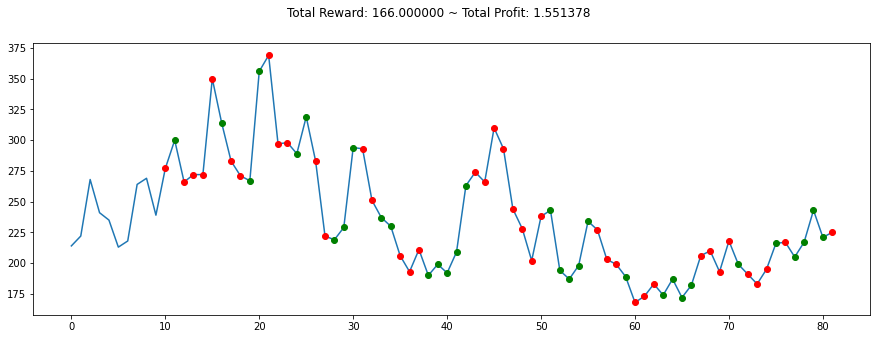

In [61]:
# Test Set - B03
env = MyCustomEnv(df=dataframe3, window_size=10, frame_bound=(10,82))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,5))
plt.cla()
env.render_all()
plt.show()

<b>Model 1 Profit using test set B03 = 55.1% return